In [8]:
import torch
import torch.nn as nn
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from rendering import rendering
from model import Voxels
from tqdm import tqdm
from ml_helpers import training 
from dataset import get_rays

In [9]:
class Nerf(nn.Module):
    
    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
        super(Nerf, self).__init__()
        
        self.block1 = nn.Sequential(nn.Linear(Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1),) #256 + 1(sigma)
        
        self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir * 6 + 3, hidden_dim // 2), nn.ReLU(),
                                      nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())
        
        self.Lpos = Lpos
        self.Ldir = Ldir
        
    def positional_encoding(self, x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)
            
                                    
        
    def forward(self, xyz, d):
        
        x_emb = self.positional_encoding(xyz, self.Lpos) # [batch_size, Lpos * 6 + 3]
        d_emb = self.positional_encoding(d, self.Ldir) # [batch_size, Ldir * 6 + 3]
        
        h = self.block1(x_emb) # [batch_size, hidden_dim]
        h = self.block2(torch.cat((h, x_emb), dim=1)) # [batch_size, hidden_dim + 1]
        sigma = h[:, -1]
        h = h[:, :-1] # [batch_size, hidden_dim]
        c = self.rgb_head(torch.cat((h, d_emb), dim=1))
        
        return c, torch.relu(sigma)
        
    
    def intersect(self, x, d):
        return self.forward(x, d)


# Camera/Dataset

In [18]:
batch_size = 1024

# Train dataloader
o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(-1, 3).type(torch.float),
    torch.from_numpy(d).reshape(-1, 3).type(torch.float),
    torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)
), dim=1), batch_size=batch_size, shuffle=True)

# Warmup dataloader
dataloader_warmup = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
    torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
    torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3)
), dim=1), batch_size=batch_size, shuffle=True)

# Test dataloader
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

In [19]:
test_o.shape

(10, 160000, 3)

In [20]:
# so we can say we have 10 test images and 400*400 images and 3 dimension

# Rendering

# Model

In [21]:
model = Voxels(scale=1.5)

In [22]:
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

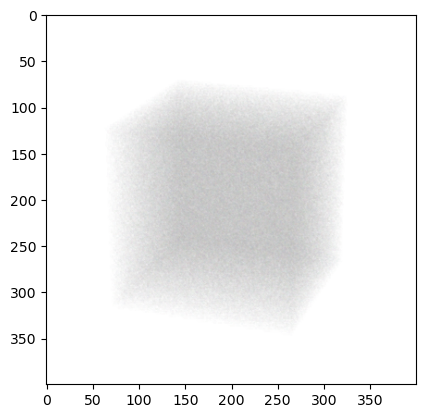

In [23]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

# Training

In [1]:
import torch
print(torch.cuda.is_available())

False


In [24]:
device = 'cuda'
nb_epochs = 1
lr = 1e-3
tn = 8
tf = 12
nb_bins = 100
gamma = 0.5

model = Nerf()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma) # torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)

  2%|▏         | 219/14063 [04:34<4:49:19,  1.25s/it]


KeyboardInterrupt: 

In [ ]:
training_loss

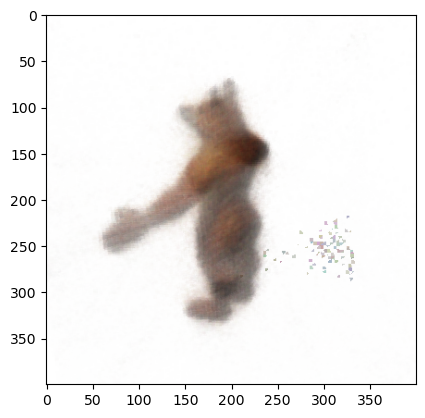

In [11]:
img = rendering(model, torch.from_numpy(o[0]), torch.from_numpy(d[0]).to(device), tn, tf, nb_bins=nb_bins, device=device)

plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())
#here all the black values become white or equal 1 because we have normalized the values (in the rendering function) with white_bckgr=True and we have added 1 to it

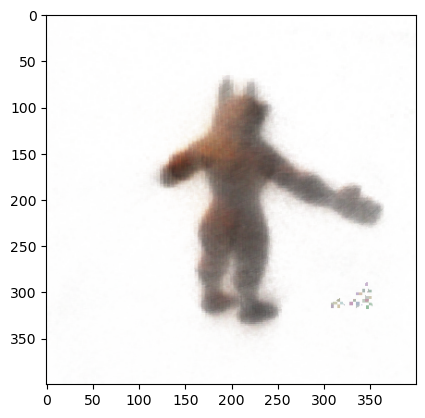

In [12]:
img = rendering(model, torch.from_numpy(o[2]), torch.from_numpy(d[2]).to(device), tn, tf, nb_bins=nb_bins, device=device)

plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())
#here all the black values become white or equal 1 because we have normalized the values (in the rendering function) with white_bckgr=True and we have added 1 to it

In [13]:
torch.save(model, 'model_voxels')

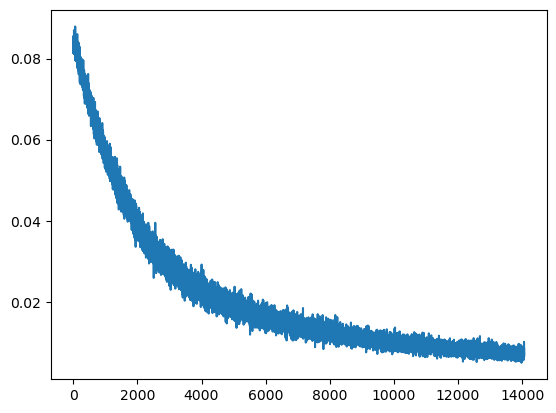

In [14]:
plt.plot(training_loss)

In [15]:
print(training_loss)


[0.0827212343214057, 0.08556026165037484, 0.08435960663413324, 0.08136221351033683, 0.0833775720149399, 0.08527076527962041, 0.08438180301604596, 0.08379284156486862, 0.08244030005111293, 0.08492476114642722, 0.08343593998523195, 0.0829646524127146, 0.08340233575673243, 0.08330316578158775, 0.08348651254703661, 0.08122805003395041, 0.08150286011964962, 0.08497581550216989, 0.08277905240471964, 0.08261754617341797, 0.0838196833238684, 0.08646161073115305, 0.08121621097743435, 0.08700297943658848, 0.08307101386314532, 0.08617577553197202, 0.08173593874165296, 0.0815680133328922, 0.08313043156652468, 0.08562277033580995, 0.0828454557943594, 0.08626007351030511, 0.08425715812486585, 0.08310778062523838, 0.08149026374789224, 0.08207637423846909, 0.08620633833394759, 0.08355312808050046, 0.08378391380707685, 0.08433414411661093, 0.08225105050975035, 0.08347286336969058, 0.08381745381161887, 0.08262830444934065, 0.08296664844169012, 0.08292046340247156, 0.08147423154297619, 0.0866545207614471

In [24]:
device = 'cpu'
nb_epochs = 15
lr = 1e-3
tn = 8
tf = 12
nb_bins = 100
gamma = 0.5

model = Voxels(scale=3, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma) # torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)

100%|██████████| 14063/14063 [03:34<00:00, 65.45it/s]


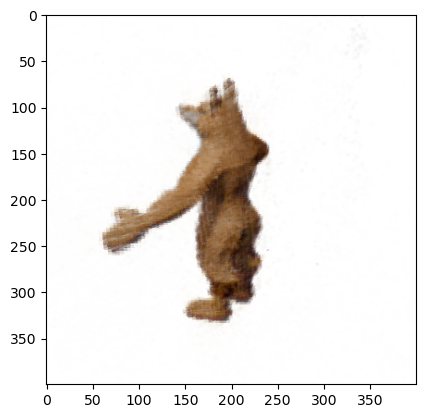

In [25]:
img = rendering(model, torch.from_numpy(o[0]), torch.from_numpy(d[0]).to(device), tn, tf, nb_bins=nb_bins, device=device)

plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

In [29]:
print(training_loss)

[0.08447730730047197, 0.08337973529652605, 0.08454504036132289, 0.08395197962462055, 0.08311950009813383, 0.08587369532592067, 0.08175445475899216, 0.08345122374012766, 0.0827749647749721, 0.0835659944197662, 0.08475459967365025, 0.0829978797873107, 0.08426447183918613, 0.08725344549989206, 0.08503953279756586, 0.08572142871180986, 0.08353835962446447, 0.08164445795926038, 0.08345650297255401, 0.08385846367103977, 0.08617472429597221, 0.08674491141390865, 0.08561813058382102, 0.08228435135976767, 0.08541886908135866, 0.08235619007297608, 0.08283083346308061, 0.07992202145428008, 0.08348529029638253, 0.08229284186191732, 0.085577370926941, 0.08135576444986348, 0.08149220051474428, 0.08517722909241354, 0.08435491994364104, 0.08248344616094665, 0.0819563662296456, 0.0840784806330873, 0.08389932526577444, 0.0841690080911628, 0.08535255452034779, 0.08125041243947667, 0.08193060175426191, 0.08353441721405357, 0.08342277829579052, 0.08366303051919961, 0.08387199831486376, 0.08289235373543856,

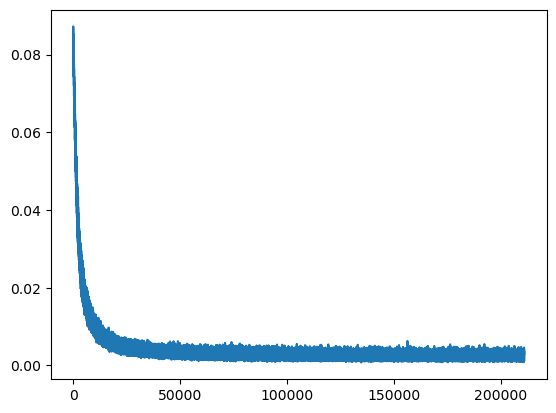

In [30]:
plt.plot(training_loss)

In [2]:
100**3 / 1e6

1.0

In [ ]:
import torch
import torch.nn as nn
import tinycudann as tcnn

class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()
        
        self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), 
                                                    device=device, requires_grad=True))
        
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, xyz, d):
        
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]
        
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))
        
        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1]
         
        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])
        
    
    def intersect(self, x, d):
        return self.forward(x, d)
    
    
class Nerf(nn.Module):
    
    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
        super(Nerf, self).__init__()
        
        self.block1 = nn.Sequential(nn.Linear(Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1),)
        
        self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir * 6 + 3, hidden_dim // 2), nn.ReLU(),
                                      nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())
        
        self.Lpos = Lpos
        self.Ldir = Ldir
        
    def positional_encoding(self, x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)
            
                                    
        
    def forward(self, xyz, d):
        
        x_emb = self.positional_encoding(xyz, self.Lpos) # [batch_size, Lpos * 6 + 3]
        d_emb = self.positional_encoding(d, self.Ldir) # [batch_size, Ldir * 6 + 3]
        
        h = self.block1(x_emb) # [batch_size, hidden_dim]
        h = self.block2(torch.cat((h, x_emb), dim=1)) # [batch_size, hidden_dim + 1]
        sigma = h[:, -1]
        h = h[:, :-1] # [batch_size, hidden_dim]
        c = self.rgb_head(torch.cat((h, d_emb), dim=1))
        
        return c, torch.relu(sigma)
        
    
    def intersect(self, x, d):
        return self.forward(x, d)
